# CONVERSOR WAV > PARTITURA

Primer paso: Reconocimiento de tonos

In [1]:
# Imports
from scipy.io import wavfile
import os
import numpy as np
from scipy.signal import find_peaks,correlate
import pandas as pd
from sklearn.cluster import KMeans

# Inputs
PATH = 'C:\\Users\\Javier\\Desktop\\TFG\\ReconocimientoDeTonos'      # Path of project's directory
AUDIO_FILE = 'DoM-piano.wav'                                         # Audio file's name
WINDOW_SIZE_SECS = 1.0                                               # Size of the fft window in seconds
OVERLAPPING_SECS = 0.5                                              # Window's overlapping in seconds
SILENCE_THRESHOLD = 0.0001                                           # Intensity threshold for silence in [0,1]
INTENSITY_THRESHOLD = 0.001                                          # Intensity (relevance) threshold for frequencies
MAX_REL_PEAKS = 12                                                   # Maximum number of peaks in the cluster of relevant peaks
N_NOTES_CORRECTION_L = 4                                             # Number of notes to the left to consider for correcting a note
N_NOTES_CORRECTION_R = 0                                             # Number of notes to the right to consider for correcting a note
MAX_KM_ITERATIONS = 50                                               # Maximum number of K-Means iterations
MAX_CORRECTIONS = 1                                                  # Maximum number of corrections

# Global variables 
NOTES = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]       # The twelve notes' names
SAMPLE_RATE, data = wavfile.read(os.path.join(PATH,AUDIO_FILE))      # Get sample rate (samples per second) and signal data
signal = data if data.ndim == 1 else data.T[0]                       # Get the first channel
WINDOW_SIZE_SAMPLES = int(SAMPLE_RATE * WINDOW_SIZE_SECS)            # Size of the fft window in samples
OVERLAPPING_SAMPLES = int(SAMPLE_RATE * OVERLAPPING_SECS)            # Size of overlapping in samples
AUDIO_SIZE_SECS = len(signal) / SAMPLE_RATE                          # Size of the audio file in seconds

# Files' statistics
print("Sample rate: " + str(SAMPLE_RATE) + " Hz")                   
print("Signal: " + str(signal))                                      
print("Window size: " + str(WINDOW_SIZE_SECS) + " s = " + str(WINDOW_SIZE_SAMPLES) + " samples")
print("Overlapping: " + str(OVERLAPPING_SECS) + " s = " + str(OVERLAPPING_SAMPLES) + " samples")
print("Audio length: " + str(AUDIO_SIZE_SECS) + " s")

# Functions
def freq_to_number(f):                                                      # Transforms any note's frequency into its midi number 
    return 69 + 12*np.log2(f/440.0)    

def number_to_freq(n):                                                      # Transforms any note's midi number into its frequency
    return 440 * 2.0**((n-69)/12.0)

def note_name(n):                                                           # Gets the note's name given its midi number
    return NOTES[n % 12] + str(int(n/12 - 1))

def extract_window(audio, window_number):                                   # Returns samples of window number <window-number> and true or false whether it's the last window 
    begin = window_number * (WINDOW_SIZE_SAMPLES - OVERLAPPING_SAMPLES)
    end = begin + WINDOW_SIZE_SAMPLES
    
    if end < len(signal): # Commonly
        return False, audio[begin:end]
    else: # The window surpasses the audio data => Complete last elements of the window with zeros
        return True, np.concatenate([audio[begin:len(signal)-1],np.zeros(end-len(signal)+1,dtype=float)])
    
def autocorrelation(window):                                                # Autocorrelation of a given window
    ac = correlate(window,window,mode='full')
    return ac[int(len(ac)/2):]
    
def indexes(freqs,i1,i2,harmonic):                                          # Returns h1 and h2 indexes of the nearest two 
    if i2-i1 == 1:                                                          #     harmonics of window's fund. to harmonic or
        if harmonic == freqs[i1]:                                           #     h1 the index of harmonic in freqs and h2<0
            return i1,-1
        elif harmonic == freqs[i2]:
            return i2,-1
        else:
            return i1,i2
    else:
        isplit = int(i1 + np.ceil((i2-i1)/2.0))
        if harmonic < freqs[isplit]:
            return indexes(freqs,i1,isplit,harmonic)
        elif harmonic > freqs[isplit]:
            return indexes(freqs,isplit,i2,harmonic)
        else:
            return isplit,-1
        
def remove_duplicates(seq): # Remove duplicates preserving order
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def detect_peaks(freqs,F): # Returns the array of freqs where fft has relevant peaks
    peaks_before = []
    peaks_after = []
    pindex = find_peaks(F)
    if not len(pindex[0]):
        return []
    num_clusters = 2
    nIterations = 0
    P = pd.DataFrame(data=[F[i] for i in pindex[0]],index=pindex[0],columns=['Intensity'])
    
    kmeans = KMeans(n_clusters=num_clusters,n_init=5,random_state=123456)
    clusters = kmeans.fit_predict(P) # Detect two clusters: peaks and non peaks
    cluster_id = clusters[np.argmin([F[i] for i in pindex[0]])] # Cluster of non relevant peaks id
    rpindex = np.where(clusters != cluster_id)[0] # Indexes of relevant peaks
    peaks_after = [freqs[i] for i in [pindex[0][j] for j in rpindex]]
    num_clusters += 1
    peaks_before = peaks_after.copy()
    while len(peaks_after) <= MAX_REL_PEAKS and nIterations < MAX_KM_ITERATIONS:
        peaks_before = peaks_after.copy()
        nIterations += 1
        kmeans = KMeans(n_clusters=num_clusters,n_init=5,random_state=123456)
        clusters = kmeans.fit_predict(P) # Detect <num_clusters> clusters
        cluster_id = clusters[np.argmin([F[i] for i in pindex[0]])] # Cluster of non relevant peaks id
        rpindex = np.where(clusters != cluster_id)[0] # Indexes of relevant peaks
        peaks_after = [freqs[i] for i in [pindex[0][j] for j in rpindex]]
        num_clusters += 1
        
    return peaks_before

def find_candidates(cset): # Finds candidates for fundamental by substracting elements in cset
    aux_cset = [c for c in cset if c >= 27.5].copy() # Remove too low freqs
    aux_cset.sort() # Order
    candidates = aux_cset.copy()
    for i in range(0,len(aux_cset)-1):
        candidate = number_to_freq(int(round(freq_to_number(aux_cset[i+1] - aux_cset[i])))) # Round to equal temperament
        if candidate not in candidates:
            candidates.append(candidate)
    return [c for c in candidates if c >= 27.5] # Remove too low freqs

def count_harmonics(peaks,candidates,m): # Count the number of harmonics in peaks for each candidate
    nharmonics = np.zeros(len(candidates),dtype=float)
    for i in range(0,len(candidates)):
        for j in range(0,len(peaks)):
            if peaks[j] >= candidates[i]:
                div = np.modf(peaks[j]/candidates[i])[0]
                if np.abs(div-round(div)) < 0.01: # Check if harmonic
                    nharmonics[i] += 1
    for i in range(0,len(candidates)):
        samples = max(1,round(m/candidates[i]))
        nharmonics[i] /= np.power(samples,0.1)
        
    return nharmonics

def count_differences(peaks): # Count the number of harmonics in peaks for each candidate
    aux_peaks = peaks.copy()
    aux_peaks.sort()
    aux_peaks.insert(0,0.0);
    differences = []
    counts = []
    
    for i in range(0,len(aux_peaks)):
        for j in range(i+1,len(aux_peaks)):
            diff = number_to_freq(int(round(freq_to_number(aux_peaks[j] - aux_peaks[i]))))
            if diff not in differences:
                differences.append(diff)
                counts.append(1)
            else:
                counts[differences.index(diff)] += 1
        
    return differences[np.argmax(counts)]

def max_amplitude(fund,freqs,F): # Compute the maximum of amplitudes in fund harmonics as weight of the note
    max_amp = 0
    num_harmonic = 1
    harmonic = num_harmonic * fund
    top_freq = (len(F)-1) * freqs[1] 
    while harmonic <= top_freq:
        # Compute the indexes of the nearest two harmonics of window's fund. to harmonic
        h1,h2 = indexes(freqs,0,len(freqs)-1,harmonic) 
        if h2 < 0:
            max_amp = max([max_amp,F[h1]])
        else:
            # Weighted mean of F[h1] and F[h2] by distance of freqs[h1] and freqs[h2] to the harmonic
            if freqs[h1] != 0:
                max_amp = max([max_amp,(F[h1]*np.log2(freqs[h2]/harmonic) + F[h2]*np.log2(harmonic/freqs[h1])) / np.log2(freqs[h2]/freqs[h1])])

        num_harmonic += 1
        harmonic = num_harmonic * fund
        
    return max_amp
    
def detect_note(fft):
    freqs = np.fft.rfftfreq(WINDOW_SIZE_SAMPLES, 1/SAMPLE_RATE) # The array of frequencies to evaluate in the fft
    F = np.abs(fft.real) # Evaluations of those frequencies
    
    peaks = [number_to_freq(round(freq_to_number(i))) for i in detect_peaks(freqs,F)] # Round to equal temperament
    if not len(peaks):
        return ('S',0)
    peaks = remove_duplicates(peaks) # Remove duplicates
     
    candidates = find_candidates(peaks)
    nharmonics = count_harmonics(peaks,candidates,freqs[-1]) 

    pred_fund = candidates[np.argmax(nharmonics)]
    
    return (note_name(int(round(freq_to_number(pred_fund)))),max_amplitude(pred_fund,freqs,F))

def correct_notes_iteration(notes,weights,nl,nr): # Correct each note according to its nl previous and nr following ones' weights
    cnotes = notes.copy() # Necessary for keeping the first and last notes
    cweights = weights.copy() # Necessary for keeping the first and last weights
    
    silence_threshold = SILENCE_THRESHOLD * max(cweights)
    n = max(nl,nr)
    w = [1] # New weights for the window, based on proximity to the note to be corrected
    for k in range(1,n+1):
        w.append(sum(w))
        
    for i in range(0,len(notes)-nr):
        if cnotes[i] == 'S': # Avoid correcting silence
            continue
        if cweights[i] <= silence_threshold: # Correct as silence and keep the weight
            cnotes[i] = 'S'
            continue
            
        if i in range(0,nl) or i in range(len(notes)-nr,len(notes)): # Skip if cannot be corrected for being out of the range
            continue
        
        nsubset = []
        wsubset = []
        nsums = []
        for j in range(i-nl,i+nr+1):
            if notes[j] not in nsubset:
                nsubset.append(notes[j])
                if j <= i:
                    wsubset.append(w[j-(i-n)] * weights[j])
                    nsums.append(w[j-(i-n)])
                else:
                    wsubset.append(w[i+n-j] * weights[j] / 2) # Little penalization to future notes
                    nsums.append(w[i+n-j] / 2)
            else:
                if j <= i:
                    wsubset[nsubset.index(notes[j])] += w[j-(i-n)] * weights[j]
                    nsums[nsubset.index(notes[j])] += w[j-(i-n)]
                else:
                    wsubset[nsubset.index(notes[j])] += w[i+n-j] * weights[j] / 2
                    nsums[nsubset.index(notes[j])] += w[i+n-j] / 2
                  
        index = len(wsubset) - wsubset[::-1].index(max(wsubset)) - 1 # Index of last maximum of wsubset
        cnotes[i] = nsubset[index]
        cweights[i] = wsubset[index] / nsums[index]
        
    return cnotes,cweights

def correct_notes(notes,weights,nl,nr): # Correct the notes
    count = 0
    
    notes_before = notes.copy()
    notes_after,cweights = correct_notes_iteration(notes,weights,nl,nr)
    while not np.array_equal(notes_before,notes_after) and count < MAX_CORRECTIONS:
        notes_before = notes_after.copy()
        count += 1
        notes_after,cweights = correct_notes_iteration(notes_before,cweights,nl,nr)
    
    return notes_before

def notes_per_window():
    hanning = 0.5 * (1 - np.cos(np.linspace(0,2*np.pi,WINDOW_SIZE_SAMPLES,False)))  # The hanning window function

    notes = []
    weights = []
    window_number = 0
    last_window = False
    while not(last_window):
        last_window, window = extract_window(signal,window_number)
        window_number += 1
        fft = np.fft.rfft(autocorrelation(window * hanning))
        note,weight = detect_note(fft)
        notes.append(note)
        weights.append(weight)
       
    return correct_notes(notes,weights,N_NOTES_CORRECTION_L,N_NOTES_CORRECTION_R)    

Sample rate: 44100 Hz
Signal: [0.01104736 0.01083374 0.01083374 ... 0.         0.         0.        ]
Window size: 1.0 s = 44100 samples
Overlapping: 0.5 s = 22050 samples
Audio length: 13.933469387755101 s


<ipython-input-1-8243285d7541>:24: WavFileWarning: Chunk (non-data) not understood, skipping it.
  SAMPLE_RATE, data = wavfile.read(os.path.join(PATH,AUDIO_FILE))      # Get sample rate (samples per second) and signal data


In [2]:
npw = notes_per_window()
print(npw)

['C4', 'D4', 'D4', 'E4', 'C4', 'F4', 'F4', 'F4', 'F4', 'F4', 'B4', 'B4', 'B4', 'B4', 'B4', 'B4', 'A4', 'G4', 'G4', 'F4', 'F4', 'F4', 'F4', 'D4', 'C4', 'C4', 'C4']


Segundo paso: Cálculo de duraciones

In [3]:
# Inputs
QUARTER_PPM = 62                                                     # Tempo in terms of a quarter
QUANTIZATION_FACTOR = 4                                              # Briefest musical figure to consider

# Global variables
QUARTER_SECS = 60.0 / QUARTER_PPM                                    # Seconds of a quarter

# Functions
def durations(n_prev,d_prev): # Compute the arrays of notes and durations (in seconds) from previous array or not
    notes = []
    durations = []
    
    cn = n_prev[0] # Current note
    cnd = 0 # Current note's duration
    if not d_prev:
        for n in n_prev:
            if n == cn:
                cnd += WINDOW_SIZE_SECS - OVERLAPPING_SECS
            else:
                notes.append(cn)
                durations.append(cnd)
                cn = n
                cnd = WINDOW_SIZE_SECS - OVERLAPPING_SECS
        notes.append(cn)
        durations.append(cnd + OVERLAPPING_SECS)
    else:
        for i in range(0,len(n_prev)):
            if n_prev[i] == cn:
                cnd += d_prev[i]
            else:
                notes.append(cn)
                durations.append(cnd)
                cn = n_prev[i]
                cnd = d_prev[i]
        notes.append(cn)
        durations.append(cnd)
      
    return notes,durations

def to_quarters(durations,subdivision): # Compute the array of durations (in quarters)
    return np.round(subdivision * np.array(durations) / QUARTER_SECS) / subdivision

def remove_zeros(n,d,q,remove_rests): 
    notes = []
    durations = []
    quarters = []
    for i in range(0,len(n)):
        if q[i] > 0 or (n[i] == 'S' and not remove_rests):
            notes.append(n[i])
            durations.append(d[i])
            quarters.append(q[i])
            
    return notes,durations,quarters

def final_notes_durations(npw,subdivision): # Compute the final arrays of notes and durations (in seconds and quarters)
    n_before = npw.copy()
    d = []
    q = []
    
    n_after,d = durations(n_before,d)
    q = to_quarters(d,subdivision)
    n_after,d,q = remove_zeros(n_after,d,q,False)
    while not np.array_equal(n_before,n_after):
        n_before = n_after.copy()
        n_after,d = durations(n_before,d)
        q = to_quarters(d,subdivision)
        n_after,d,q = remove_zeros(n_after,d,q,False)
    
    return remove_zeros(n_before,d,q,True) # To considering little rests as separators between equal notes

In [4]:
notes,durations,quarters = final_notes_durations(npw,QUANTIZATION_FACTOR)
print(notes)
print(durations)
print(quarters)

['C4', 'D4', 'E4', 'C4', 'F4', 'B4', 'A4', 'G4', 'F4', 'D4', 'C4']
[0.5, 1.0, 0.5, 0.5, 2.5, 3.0, 0.5, 1.0, 2.0, 0.5, 2.0]
[0.5, 1.0, 0.5, 0.5, 2.5, 3.0, 0.5, 1.0, 2.0, 0.5, 2.0]


Tercer paso: Conversión a partitura

In [5]:
# Imports
from music21 import *

# Inputs
SIGNATURE_NUM = 4
SIGNATURE_DEN = 4
TITLE = 'Partitura'
COMPOSER = 'WAV2MIDIConverter'

# Functions
def music_sheet(notes,quarters):
    score = stream.Score() # Score
    part = stream.Part() # Staff
    voice = stream.Voice() # Voice
    
    voice.append(meter.TimeSignature(str(SIGNATURE_NUM) + '/' + str(SIGNATURE_DEN))) # Define time signature
    
    first_note = False # We allow clef changes after insertion of the fist note (not rest)
    for i in range(0,len(notes)):
        if notes[i] == 'S':
            voice.append(note.Rest(quarters[i]))
            continue
        n = note.Note(notes[i])
        n.duration = duration.Duration(quarters[i])
        
        cclef = None
        if voice.getElementsByClass('Clef'): # Get current clef
            cclef = voice.getElementsByClass('Clef')[len(voice.getElementsByClass('Clef'))-1]
        else:
            cclef = clef.bestClef(voice)

        if first_note and n.octave < 4 and cclef == clef.TrebleClef(): # Condition to change to F clef
            voice.append(clef.BassClef())
        if first_note and n.octave > 3 and cclef == clef.BassClef(): # Condition to change to G clef
            voice.append(clef.TrebleClef())
        
        voice.append(n)
        first_note = True
        
        
    quarters_in_measure = 4 * SIGNATURE_NUM / SIGNATURE_DEN
    last_silence_quarters = quarters_in_measure - (sum(quarters) % quarters_in_measure)
    voice.append(note.Rest(last_silence_quarters)) # Last silence duration to end last measure
    
    part.append([voice])
    score.insert(0,part)
    
    score.insert(0, metadata.Metadata())
    score.metadata.title = TITLE
    score.metadata.composer = COMPOSER
    
    score.show()
    #score.write('musicxml.pdf', fp='marcha.pdf')
    score.write('midi', fp='partitura.midi')

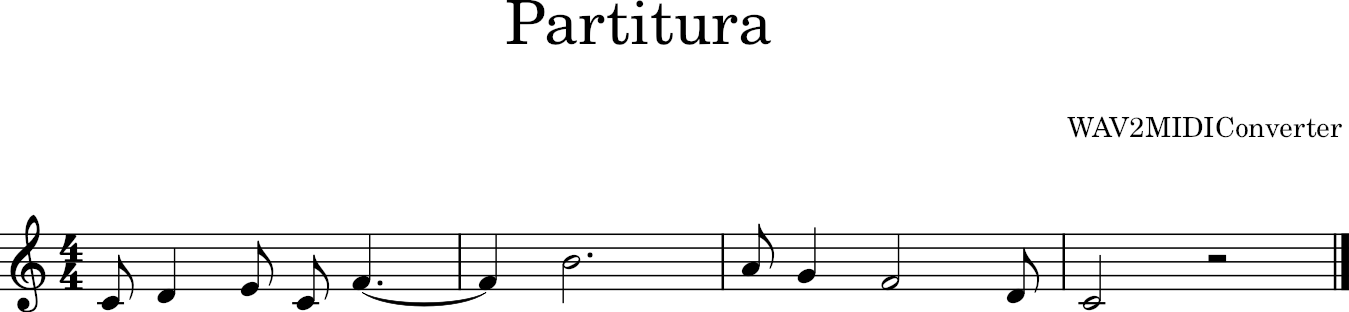

In [6]:
music_sheet(notes,quarters)